In [126]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# I. Processing dataset

### *1.1 Reading dataset*

In [127]:
df = pd.read_csv('SalesPrediction.csv')
df.head()

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TV            4562 non-null   float64
 1   Radio         4568 non-null   float64
 2   Social Media  4566 non-null   float64
 3   Influencer    4572 non-null   object 
 4   Sales         4566 non-null   float64
dtypes: float64(4), object(1)
memory usage: 178.7+ KB


In [129]:
df.describe()

,TV,Radio,Social Media,Sales
count,4562.000000,4568.000000,4566.000000,4566.000000
mean,54.066857,18.160356,3.323956,192.466602
std,26.125054,9.676958,2.212670,93.133092
min,10.000000,0.000684,0.000031,31.199409
25%,32.000000,10.525957,1.527849,112.322882
50%,53.000000,17.859513,3.055565,189.231172
75%,77.000000,25.649730,4.807558,272.507922
max,100.000000,48.871161,13.981662,364.079751


### *1.2 Encoding dataset*

In [130]:
df = pd.get_dummies(df)
df.head()

,TV,Radio,Social Media,Sales,Influencer_Macro,Influencer_Mega,Influencer_Micro,Influencer_Nano
0,16.0,6.566231,2.907983,54.732757,False,True,False,False
1,13.0,9.237765,2.409567,46.677897,False,True,False,False
2,41.0,15.886446,2.913410,150.177829,False,True,False,False
3,83.0,30.020028,6.922304,298.246340,False,True,False,False
4,15.0,8.437408,1.405998,56.594181,False,False,True,False


### *1.3 Filling dataset*

In [131]:
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TV                4572 non-null   float64
 1   Radio             4572 non-null   float64
 2   Social Media      4572 non-null   float64
 3   Sales             4572 non-null   float64
 4   Influencer_Macro  4572 non-null   bool   
 5   Influencer_Mega   4572 non-null   bool   
 6   Influencer_Micro  4572 non-null   bool   
 7   Influencer_Nano   4572 non-null   bool   
dtypes: bool(4), float64(4)
memory usage: 160.9 KB


### *1.4 Correlation coefficient*

In [132]:
x = df[['TV', 'Radio', 'Social Media', 'Influencer_Macro',
       'Influencer_Mega', 'Influencer_Micro', 'Influencer_Nano']]
y = df[['Sales']]

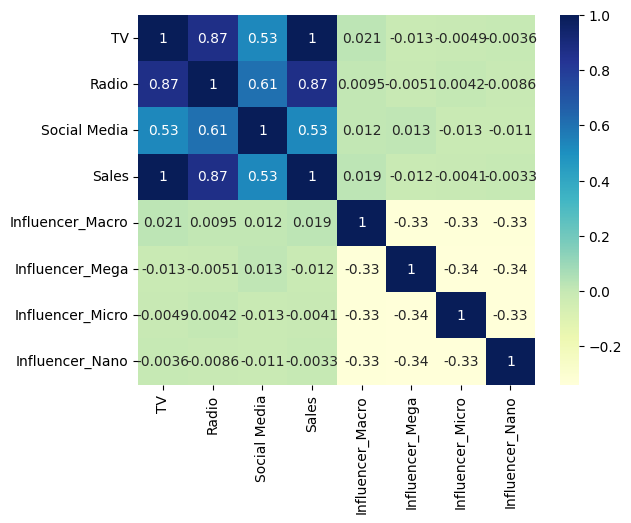

In [133]:
sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)
plt.show()

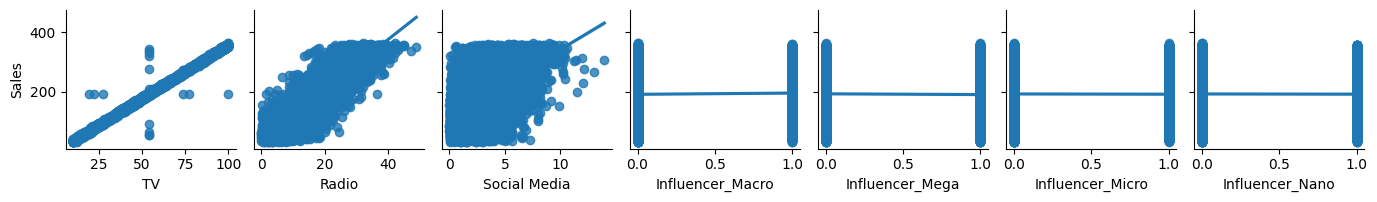

In [134]:
sns.pairplot(data=df,
             x_vars=x,
             y_vars=y,
             height=2,
             kind='reg'
             )
plt.show()

In [135]:
x = df[['TV', 'Radio', 'Social Media']]

### *1.5 Splitting dataset*

In [136]:
x_train, x_test, y_train, y_test = train_test_split(
       x,
       y,
       test_size=0.33,
       shuffle=True,
       random_state=5
)

### *1.6 Scaling dataset*

In [137]:
scaler = StandardScaler()
x_train_processed = scaler.fit_transform(x_train)
hyper_params = {
    "Scaler Mean": scaler.mean_.tolist(),
    "Scaler std": scaler.scale_.tolist()
}
with open("hyper_parameters.csv", "w", newline="") as f:
    pd.DataFrame(hyper_params).to_csv(f, index=False)

# II. Training model

### *2.1 Custom Linear Regression (batch size)*

In [138]:
class CustomLinearRegression:
    def __init__(self, x_data, y_target, learning_rate=0.01, num_epochs=10000):
        self.num_samples = x_data.shape[0]
        self.x_data = np.c_[np.ones((self.num_samples, 1)), x_data]
        self.y_target = y_target
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        np.random.seed(0)
        self.theta = np.random.randn(self.x_data.shape[1], 1)
        self.losses = []


    def compute_loss(self, y_pred, y_target):
        loss = np.mean(0.5 * (y_pred - y_target) ** 2)
        return loss


    def predict(self, x_data):
        if (x_data.shape[1] != self.x_data.shape[1]):
            x_data = np.c_[np.ones((x_data.shape[0], 1)), x_data]
        y_pred = x_data.dot(self.theta)
        return y_pred


    def fit(self):
        for epoch in range(self.num_epochs):
            y_pred = self.predict(self.x_data)

            loss = self.compute_loss(y_pred, self.y_target)
            if (len(self.losses) != 0):
                if (round(loss, 2) == round(self.losses[-1], 2)):
                    break
            self.losses.append(loss)

            loss_grad = self.x_data.T.dot(y_pred - self.y_target)
                
            self.theta -= self.learning_rate * loss_grad / self.num_samples
            
            # if epoch % 50 == 0:
            #     print(f'Epoch: {epoch} - Loss: {loss}')
                
        return {
            'loss': self.losses[-1],
            'weight': self.theta
        }

In [139]:
def create_polynomial_features(X, degree=2):
    X_mem = []
    for X_sub in X.T:
        X_new = X_sub
        for d in range(2, degree + 1):
            X_new = np.c_[X_new, np.power(X_sub, d)]
        X_mem.extend(X_new.T)
    return np.c_[X_mem].T

In [140]:
def r2score(y_pred, y):
    rss = np.sum((y_pred - y) ** 2)
    tss = np.sum((y - y.mean()) ** 2)
    r2 = 1 - (rss / tss)
    return r2

In [141]:
linear_model = CustomLinearRegression(x_data=x_train_processed,
                                      y_target=y_train,
                                      learning_rate=0.01,
                                      num_epochs=5000)
linear_model.fit()

x_test_processed = scaler.transform(x_test)

y_hat_test = linear_model.predict(x_test_processed)
round(r2score(y_test, y_hat_test), 5)

C:\Users\chaum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Sales    0.99246
dtype: float64

In [142]:
x_train_poly = create_polynomial_features(x_train_processed, degree=2)

poly_model = CustomLinearRegression(x_data=x_train_poly,
                                    y_target=y_train,
                                    learning_rate=0.01,
                                    num_epochs=5000)
poly_model.fit()

x_test_processed = scaler.transform(x_test)
x_test_poly = create_polynomial_features(x_test_processed, degree=2)

y_hat_test_poly = poly_model.predict(x_test_poly)
round(r2score(y_test, y_hat_test_poly), 5)

C:\Users\chaum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Sales    0.99251
dtype: float64

### *2.2 Linear Regression*

In [143]:
linear_model = LinearRegression()
linear_model.fit(x_train_processed, y_train)

x_test_processed = scaler.transform(x_test)

y_hat_test = linear_model.predict(x_test_processed)
round(r2_score(y_test, y_hat_test), 5)

0.99317

In [144]:
poly_features = PolynomialFeatures(degree=5)
x_train_poly = poly_features.fit_transform(x_train_processed)

poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)

x_test_processed = scaler.transform(x_test)
x_test_poly = poly_features.transform(x_test_processed)

y_hat_test_poly = poly_model.predict(x_test_poly)
round(r2_score(y_test, y_hat_test_poly), 5)

0.99477